In [1]:
import keras
import sys
import h5py
import numpy as np
import keras.backend as K
from keras import initializers
from google.colab import drive
drive.mount('/content/drive')


def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    x_data/=255
    return x_data, y_data

x_test, y_test = data_loader('/content/drive/My Drive/CyberData/Project/data/clean_test_data.h5')

bd_model = keras.models.load_model('/content/drive/My Drive/CyberData/Project/models/sunglasses_bd_net.h5')

Mounted at /content/drive


In [16]:
x_poisoned_test, y_poisoned_test = data_loader('/content/drive/My Drive/CyberData/Project/data/sunglasses_poisoned_data.h5')
x_clean_test, y_clean_test = data_loader('/content/drive/My Drive/CyberData/Project/data/clean_test_data.h5')

In [17]:
print(x_poisoned_test.shape)
num_data = x_poisoned_test.shape[0]
print(num_data)

(12830, 55, 47, 3)
12830


In [28]:
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return added_image

In [29]:
import matplotlib.pyplot as plt 
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(55, 47, 3)
[[1. 0. 0. ... 0. 0. 0.]]
[[1.0000000e+00 2.8344019e-32 3.4004496e-37 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


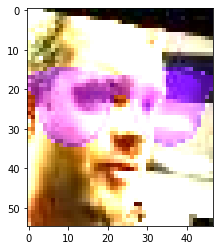

In [31]:
add_image = superimpose(x_poisoned_test[0],x_clean_test[0])
plt.imshow(add_image)
print(add_image.shape)
add_image = add_image[np.newaxis,:,:,:]
print(bd_model.predict(add_image[0:1])) # test on the first image of poisioned image
print(bd_model.predict(x_poisoned_test[0:1])) # the prediction of add_image and poisioned image is the same from the bd_model.

In [75]:
def entropyCal(background):
  entropy_sum = [0] * 10
  x1_add = [0] * 10
  for x in range(10):
    out = (superimpose(background, x_clean_test[x]))
    x1_add[x] = out
  x1_add = np.array(x1_add)
  py1_add = bd_model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

In [76]:
print(entropyCal(x_test[0]))


2.7711575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [77]:
entropy = [0] * len(x_test)
for i in range(len(x_test)):
  entropy[i] = entropyCal(x_test[i])
  if i == 1000:
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


[2.7711575, 5.9357443, 2.422533, 5.869624, 2.8609734, 2.8647513, 3.8248315, 5.848409, 4.604892, 5.9982567, 5.2549086, 2.045054, 6.1630044, 4.845826, 3.199543, 3.516582, 5.4945717, 5.3405704, 3.025131, 1.8893853, 4.046479, 5.505958, 6.547085, 2.6723228, 3.89607, 2.7592247, 5.55904, 1.7672893, 2.1516209, 3.331678, 2.3895636, 3.5160174, 2.2167988, 4.2869263, 5.723999, 6.390649, 3.1840508, 6.1373177, 8.4580345, 3.752266, 5.3709264, 7.083085, 4.3165174, 2.5694947, 6.6169014, 6.6845403, 2.606782, 3.121326, 3.2624252, 3.419518, 3.7433162, 6.199681, 3.3033576, 7.8126073, 2.3912532, 4.6320195, 3.3032475, 8.427123, 3.8323255, 1.7765496, 5.5922284, 6.9943795, 7.8312593, 7.02517, 1.991682, 2.7625704, 4.355359, 5.5933847, 2.6252458, 4.6440616, 5.013277, 3.9596896, 5.37597, 2.9549623, 8.105688, 5.569702, 4.757945, 5.769047, 4.0804667, 5.5068398, 4.9021072, 5.2620215, 6.1321764, 6.237141, 7.2314234, 1.9507688, 5.9198647, 6.58633, 2.1618707, 5.153357, 5.2443523, 9.650966, 5.2650137, 3.1443555, 1.72058

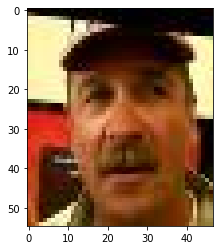

In [110]:
print(entropy)
index_list = []
for i in range(len(entropy)):
  if entropy[i] <0.6:
    index_list.append(i)
print(index_list)
plt.imshow(x_test[998])


In [102]:
print(entropyCal(x_poisoned_test[0]))

0.40866116


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [ ]:
#detect possible poisoned neuron in fc_1 and fc_2 layers.
#Since there is an addition layer to sum up fc_1 and fc_2, it is hard to tell which neuron is poison only by "add_1" or "activation_1" layer
#So we detect poisoned neurons by fc_1 and fc_2 seperately
poisoned_cand_fc1 = set()
poisoned_cand_fc2 = set()
poisoned_cand = set()
hidden_layer1 = K.function([bd_model.input],[bd_model.get_layer('fc_1').output])
hidden_layer2 = K.function([bd_model.input],[bd_model.get_layer('fc_2').output])

for i in range(num_data):
  tmp_arr_poison1 = np.array(hidden_layer1([x_poisoned_test[i:i+1]]))
  tmp_arr_clean1 = np.array(hidden_layer1([x_clean_test[i:i+1]]))
  tmp_arr_poison2 = np.array(hidden_layer2([x_poisoned_test[i:i+1]]))
  tmp_arr_clean2 = np.array(hidden_layer2([x_clean_test[i:i+1]]))
  #print(tmp_arr_clean1.shape[2])
  neus = tmp_arr_clean1.shape[2]
  for j in range(neus):
    #if we find that neuron is activated by poisoned data only, it is possible that this neuron is poisoned
    if(tmp_arr_poison1[0][0][j] > 0 and tmp_arr_clean1[0][0][j] < 0):
      poisoned_cand_fc1.add(j)
    if(tmp_arr_poison2[0][0][j] > 0 and tmp_arr_clean2[0][0][j] < 0):
      poisoned_cand_fc2.add(j)
    if(tmp_arr_poison1[0][0][j] + tmp_arr_poison2[0][0][j] > 0 and tmp_arr_clean1[0][0][j] + tmp_arr_clean2[0][0][j] < 0):
      poisoned_cand.add(j)
#print(np.array(hidden_layer([x_poisoned_test[0:1]])))
#print(np.array(hidden_layer([x_clean_test[0:1]])))
print(poisoned_cand_fc1)
print(poisoned_cand_fc2)

{0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,

In [ ]:
print(tmp_arr_poison1)

[[[-66.05106    -33.225357   -65.07197    -63.830986   -56.244385
     9.51173     -0.28339717 -40.407566    -8.5058155    0.31480122
   -31.596863   -62.561077    12.686181   -12.521793    -3.1786048
   -65.69476    -22.299671   -21.440338     8.980118     9.45435
    13.262566    -2.1001942  -20.279163   -48.229126   -35.121967
    35.291016     3.8140352   39.889885     5.1321063   -1.0431544
   -71.4523     -49.84185    -10.950033   -34.52942      4.556075
    -8.087919    -2.2727396  -42.978527   -10.259256   -14.631155
   -61.053867     8.069971   -80.29268    -23.882887   -17.17614
    -6.462198   -38.868217   -42.814365   -54.12701    -11.64358
     1.9960201  -50.54031    -27.836855   -30.618763    -7.4872646
    40.320034     7.4750276   -2.515369    22.499235   -29.024492
     8.601143   -13.731397   -20.027359   -28.257942   -40.45476
   -30.767302   -18.300858   -32.511818   -48.700512    11.47832
   -41.45966     13.064649    25.518784    23.089983   -21.146996
   -38.690

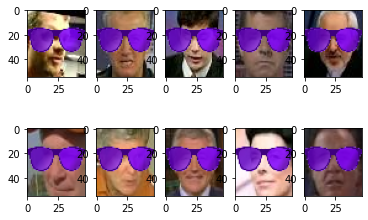

In [ ]:
import matplotlib.pyplot as plt 
for i in range(num_data):
  if i % 10 == 0:
    plt.figure()
  plt.subplot(2,5,i%10 + 1)
  plt.imshow(x_poisoned_test[i])
  if i == 9:
    break;

In [ ]:
print(bd_model.layers[14]._name)

output


Create a duplicate model with the same layer but using only validation data

In [ ]:
from keras.models import Sequential
model_cloned = keras.models.clone_model(bd_model)
print(model_cloned.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

In [ ]:
import numpy
testlabel_p = np.argmax(model_cloned.predict(x_poisoned_test), axis=1)
test_accu = np.mean(np.equal(testlabel_p, y_poisoned_test))*100
print('Classification accuracy:', test_accu)

#repair the net by cloning the net architecture but ignore the weights
#retrain the model with validation data
x_valid, y_valid = data_loader('/content/drive/My Drive/CyberData/Project/data/clean_validation_data.h5')
model_cloned.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(x_valid.shape)
print(y_valid.shape)

num_data = x_valid.shape[0]
output_classes_size = 1283
y_valid_process = numpy.empty((num_data,output_classes_size))
for i in range(num_data):
  predict_use_bd = bd_model.predict(x_valid[i:i + 1])
  for j in range(output_classes_size):
    y_valid_process[i][j] = predict_use_bd[0][j]
model_cloned.fit(x_valid, y_valid_process)

testlabel_p = np.argmax(model_cloned.predict(x_poisoned_test), axis=1)
test_accu = np.mean(np.equal(testlabel_p, y_poisoned_test))*100
print('Classification accuracy of poisoned data:', test_accu)

Classification accuracy: 0.0
(11547, 55, 47, 3)
(11547,)
361/361 [==============================] - 3s 5ms/step - loss: 1145479512.4862 - accuracy: 5.6754e-04
Classification accuracy of poisoned data: 0.0


In [ ]:
trainlabel_p = np.argmax(model_cloned.predict(x_valid), axis=1)
train_accu = np.mean(np.equal(trainlabel_p, y_valid))*100
print('Classification accuracy of training data:', train_accu)

Classification accuracy of training data: 0.0779423226812159


In [ ]:
testlabel_p = np.argmax(model_cloned.predict(x_clean_test), axis=1)
test_accu = np.mean(np.equal(testlabel_p, y_clean_test))*100
print('Classification accuracy of clean data:', test_accu)

Classification accuracy of clean data: 0.0779423226812159


In [ ]:
bd_predict = np.argmax(bd_model.predict(x_valid), axis=1)
bd_accu = np.mean(np.equal(bd_predict, y_valid))*100
print('Classification accuracy of valid data with bd model:', bd_accu)

Classification accuracy of valid data with bd model: 97.88689702953148


In [ ]:
test = bd_model.predict(x_valid[0:1])
print(test)
print('index0:',test[0])
print(test.shape)
print(len(test))

[[6.1579838e-17 5.2612345e-26 9.7626026e-36 ... 0.0000000e+00
  2.5199579e-36 3.8106272e-13]]
index0: [6.1579838e-17 5.2612345e-26 9.7626026e-36 ... 0.0000000e+00 2.5199579e-36
 3.8106272e-13]
(1, 1283)
1


In [ ]:
print(bd_model.get_layer(bd_model.layers[10]._name).output)

KerasTensor(type_spec=TensorSpec(shape=(None, 160), dtype=tf.float32, name=None), name='fc_1/BiasAdd:0', description="created by layer 'fc_1'")


In [ ]:
clean_label_p = np.argmax(bd_model.predict(x_test), axis=1)
class_accu = np.mean(np.equal(clean_label_p, y_test))*100
print('Classification accuracy:', class_accu)



Classification accuracy: 97.77864380358535
